# Exploring the SVHN Data

### Importing neccessary libraries

In [53]:

from typing import List
from math import floor

import os

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchinfo import summary

# On Windows:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


### Loading the test and training data

In [22]:
train = torchvision.datasets.SVHN(root="data/", split="train", transform=torchvision.transforms.ToTensor())
test = torchvision.datasets.SVHN(root="data/", split="test", transform=torchvision.transforms.ToTensor())

### Preparing out data set

In [23]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = DataLoader(train, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([1000, 3, 32, 32])

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [38]:
def train(network: Net, optimizer, epoch: int, train_losses: List | None = None, train_counter: List | None = None):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if train_losses is not None and train_counter is not None:
      if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    #torch.save(network.state_dict(), '/results/model.pth')
    #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [39]:
def test(network: Net, test_losses: List | None = None) -> float:
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  if test_losses is not None:
    test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  return correct / len(test_loader.dataset)

In [7]:
network_zero_padding = Net()
zero_pad_optimizer = optim.SGD(network_zero_padding.parameters(), lr=learning_rate,
                      momentum=momentum)

In [8]:
train_losses_zero_padding = []
train_counter_zero_padding = []
test_losses_zero_padding = []
test_counter_zero_padding = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [9]:
print(example_data.shape)
test(network_zero_padding, test_losses_zero_padding)
for epoch in range(1, n_epochs + 1):
  train(network_zero_padding, zero_pad_optimizer, 
        epoch, train_losses_zero_padding, train_counter_zero_padding)
  test(network_zero_padding, test_losses_zero_padding)

torch.Size([1000, 3, 32, 32])


C:\Users\nawor\AppData\Local\Temp\ipykernel_18860\763589605.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
c:\Users\nawor\miniconda3\envs\cs178\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3034, Accuracy: 1977/26032 (8%)

Train Epoch: 1 [0/73257 (0%)]	Loss: 2.305881
Train Epoch: 1 [640/73257 (1%)]	Loss: 2.301186
Train Epoch: 1 [1280/73257 (2%)]	Loss: 2.298079
Train Epoch: 1 [1920/73257 (3%)]	Loss: 2.301338
Train Epoch: 1 [2560/73257 (3%)]	Loss: 2.298445
Train Epoch: 1 [3200/73257 (4%)]	Loss: 2.284375
Train Epoch: 1 [3840/73257 (5%)]	Loss: 2.279866
Train Epoch: 1 [4480/73257 (6%)]	Loss: 2.283828
Train Epoch: 1 [5120/73257 (7%)]	Loss: 2.273942
Train Epoch: 1 [5760/73257 (8%)]	Loss: 2.279344
Train Epoch: 1 [6400/73257 (9%)]	Loss: 2.286662
Train Epoch: 1 [7040/73257 (10%)]	Loss: 2.270423
Train Epoch: 1 [7680/73257 (10%)]	Loss: 2.287980
Train Epoch: 1 [8320/73257 (11%)]	Loss: 2.241739
Train Epoch: 1 [8960/73257 (12%)]	Loss: 2.272864
Train Epoch: 1 [9600/73257 (13%)]	Loss: 2.282553
Train Epoch: 1 [10240/73257 (14%)]	Loss: 2.262758
Train Epoch: 1 [10880/73257 (15%)]	Loss: 2.229692
Train Epoch: 1 [11520/73257 (16%)]	Loss: 2.190415
Train Epoch: 1 [12160/73

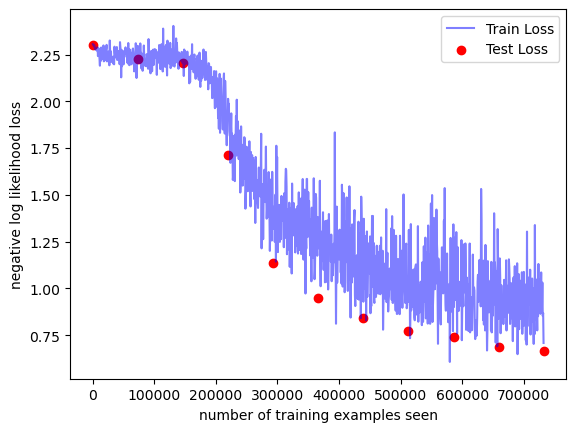

In [10]:
fig = plt.figure()
plt.plot(train_counter_zero_padding, train_losses_zero_padding, color='blue', alpha=.5)
plt.scatter(test_counter_zero_padding, test_losses_zero_padding, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig
plt.show()

In [11]:
with torch.no_grad():
  output_zero_padding = network_zero_padding(example_data)

C:\Users\nawor\AppData\Local\Temp\ipykernel_18860\763589605.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


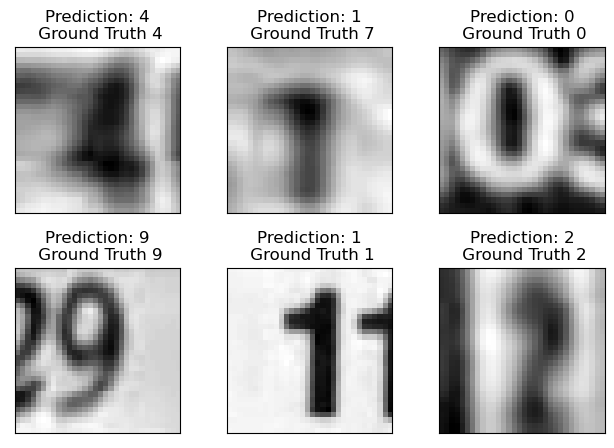

In [12]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  pred = output_zero_padding.data.max(1, keepdim=True)[1][i].item()
  plt.title("Prediction: {}\n Ground Truth {}".format(pred, example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig
plt.show()

In [43]:
class PaddedNet(nn.Module):
    def __init__(self):
        super(PaddedNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, padding=1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(720, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 720)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [44]:
network_padded = PaddedNet()
padded_optimizer = optim.SGD(network_padded.parameters(), lr=learning_rate,
                      momentum=momentum)

In [45]:

print(summary(network_padded, input_size = (batch_size_test, 3, 32, 32)))
print(summary(network_zero_padding, input_size = (batch_size_test, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
PaddedNet                                [1000, 10]                --
├─Conv2d: 1-1                            [1000, 10, 30, 30]        760
├─Conv2d: 1-2                            [1000, 20, 13, 13]        5,020
├─Dropout2d: 1-3                         [1000, 20, 13, 13]        --
├─Linear: 1-4                            [1000, 50]                36,050
├─Linear: 1-5                            [1000, 10]                510
Total params: 42,340
Trainable params: 42,340
Non-trainable params: 0
Total mult-adds (G): 1.57
Input size (MB): 12.29
Forward/backward pass size (MB): 99.52
Params size (MB): 0.17
Estimated Total Size (MB): 111.98
Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1000, 10]                --
├─Conv2d: 1-1                            [1000, 10, 28, 28]        760
├─Conv2d: 1-2                            [1000, 20, 10, 10]      

C:\Users\nawor\AppData\Local\Temp\ipykernel_18860\1182902488.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [46]:

train_losses_padded = []
train_counter_padded = []
test_losses_padded = []
test_counter_padded = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [47]:

print(example_data.shape)
test(network_padded, test_losses_padded)
for epoch in range(1, n_epochs + 1):
  train(network_padded, padded_optimizer,
        epoch, train_losses_padded, train_counter_padded)
  test(network_padded, test_losses_padded)


torch.Size([1000, 3, 32, 32])


C:\Users\nawor\AppData\Local\Temp\ipykernel_18860\1182902488.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
c:\Users\nawor\miniconda3\envs\cs178\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3221, Accuracy: 1978/26032 (8%)

Train Epoch: 1 [0/73257 (0%)]	Loss: 2.349378
Train Epoch: 1 [640/73257 (1%)]	Loss: 2.323659
Train Epoch: 1 [1280/73257 (2%)]	Loss: 2.288710
Train Epoch: 1 [1920/73257 (3%)]	Loss: 2.304565
Train Epoch: 1 [2560/73257 (3%)]	Loss: 2.305221
Train Epoch: 1 [3200/73257 (4%)]	Loss: 2.266687
Train Epoch: 1 [3840/73257 (5%)]	Loss: 2.247063
Train Epoch: 1 [4480/73257 (6%)]	Loss: 2.232051
Train Epoch: 1 [5120/73257 (7%)]	Loss: 2.238126
Train Epoch: 1 [5760/73257 (8%)]	Loss: 2.239635
Train Epoch: 1 [6400/73257 (9%)]	Loss: 2.250411
Train Epoch: 1 [7040/73257 (10%)]	Loss: 2.257600
Train Epoch: 1 [7680/73257 (10%)]	Loss: 2.258830
Train Epoch: 1 [8320/73257 (11%)]	Loss: 2.174788
Train Epoch: 1 [8960/73257 (12%)]	Loss: 2.240977
Train Epoch: 1 [9600/73257 (13%)]	Loss: 2.255032
Train Epoch: 1 [10240/73257 (14%)]	Loss: 2.267856
Train Epoch: 1 [10880/73257 (15%)]	Loss: 2.303363
Train Epoch: 1 [11520/73257 (16%)]	Loss: 2.274405
Train Epoch: 1 [12160/73

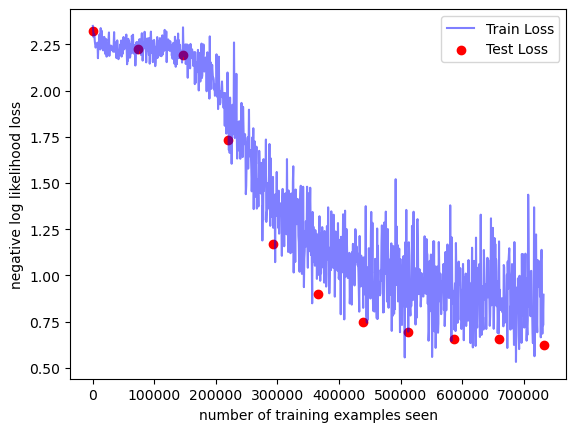

In [48]:

fig = plt.figure()
plt.plot(train_counter_padded, train_losses_padded, color='blue', alpha=.5)
plt.scatter(test_counter_padded, test_losses_padded, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig
plt.show()


In [49]:

with torch.no_grad():
  output_padded = network_padded(example_data)


C:\Users\nawor\AppData\Local\Temp\ipykernel_18860\1182902488.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


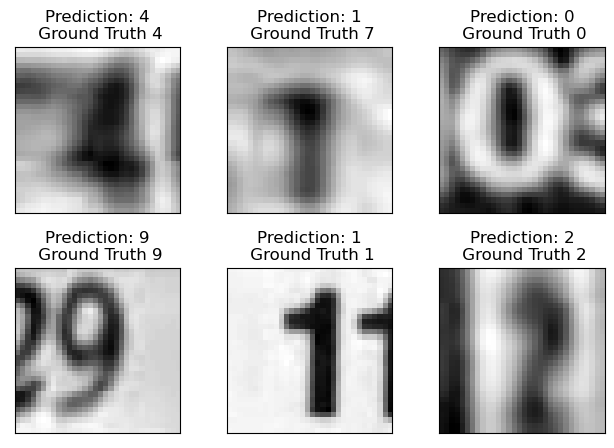

In [50]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  pred = output_padded.data.max(1, keepdim=True)[1][i].item()
  plt.title("Prediction: {}\n Ground Truth {}".format(pred, example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig
plt.show()

### Padding vs no Padding

Padding resulted in lower accuracy and higher average loss. This is likely because padding ensures that the entire image is seen by the kernel window. However, since in this dataset there is "noise" from numbers other than the target number on the edges of the image, the edges are better off ignored.

In [77]:
strides = [i for i in range(2, 6)]
error_stride = []


In [78]:
def layer_output_size(input : int, kernel, padding = 0, dilation = 1, stride = 1, max_pool = 1):
    return floor(((input + (2 * padding) - (dilation * (kernel - 1)) - 1) / stride + 1)/max_pool)

In [79]:
final_layers = layer_output_size(layer_output_size(32, 5, padding=1, max_pool=2), 5, padding=1, max_pool=2)**2 * 20
final_layers

720

In [80]:
class StrideNet(nn.Module):
    def __init__(self, stride=1):
        super(StrideNet, self).__init__()
        self.resize = layer_output_size(layer_output_size(32, 5, stride=stride, max_pool=2), 5, max_pool=2)**2 * 20
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=stride)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(self.resize, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.resize)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [81]:
for stride in strides:
    network_stride = StrideNet(stride=stride)
    print(summary(network_stride, input_size = (batch_size_test, 3, 32, 32)))
    optimizer_stride = optim.SGD(network_stride.parameters(), lr=learning_rate,
                      momentum=momentum)
    print(example_data.shape)
    test(network_stride)
    for epoch in range(1, n_epochs + 1):
        train(network_stride, optimizer_stride, epoch)
    accuracy = test(network_stride)
    error_stride.append(1 - accuracy)

C:\Users\nawor\AppData\Local\Temp\ipykernel_18860\462420094.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
StrideNet                                [1000, 10]                --
├─Conv2d: 1-1                            [1000, 10, 14, 14]        760
├─Conv2d: 1-2                            [1000, 20, 3, 3]          5,020
├─Dropout2d: 1-3                         [1000, 20, 3, 3]          --
├─Linear: 1-4                            [1000, 50]                1,050
├─Linear: 1-5                            [1000, 10]                510
Total params: 7,340
Trainable params: 7,340
Non-trainable params: 0
Total mult-adds (M): 195.70
Input size (MB): 12.29
Forward/backward pass size (MB): 17.60
Params size (MB): 0.03
Estimated Total Size (MB): 29.92
torch.Size([1000, 3, 32, 32])


c:\Users\nawor\miniconda3\envs\cs178\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3073, Accuracy: 1744/26032 (7%)


Test set: Avg. loss: 1.4762, Accuracy: 13458/26032 (52%)



c:\Users\nawor\miniconda3\envs\cs178\lib\site-packages\torch\nn\init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Conv2d: 1, Conv2d: 1, Dropout2d: 1]

In [82]:
print(error_stride)

[tensor(0.4830)]


In [83]:
class DilationNet(nn.Module):
    def __init__(self, dilation=1):
        super(DilationNet, self).__init__()
        self.resize = layer_output_size(layer_output_size(32, 5, dilation=dilation, max_pool=2), 5, max_pool=2)**2 * 20
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, dilation=dilation)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(self.resize, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.resize)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [88]:
dilations = [i for i in range(2,6)]
error_dilation = []

In [89]:
for dilation in dilations:
    network_dilation = DilationNet(dilation=dilation)
    optimizer_dilation = optim.SGD(network_dilation.parameters(), lr=learning_rate,
                      momentum=momentum)
    print(example_data.shape)
    test(network_dilation)
    for epoch in range(1, n_epochs + 1):
        train(network_dilation, optimizer_dilation, epoch)
    accuracy = test(network_dilation)
    error_dilation.append(1 - accuracy)

torch.Size([1000, 3, 32, 32])


C:\Users\nawor\AppData\Local\Temp\ipykernel_18860\1056620475.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
c:\Users\nawor\miniconda3\envs\cs178\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3108, Accuracy: 2042/26032 (8%)


Test set: Avg. loss: 0.6814, Accuracy: 21077/26032 (81%)

torch.Size([1000, 3, 32, 32])

Test set: Avg. loss: 2.3122, Accuracy: 1660/26032 (6%)


Test set: Avg. loss: 0.8935, Accuracy: 19271/26032 (74%)

torch.Size([1000, 3, 32, 32])

Test set: Avg. loss: 2.3204, Accuracy: 2188/26032 (8%)


Test set: Avg. loss: 1.3984, Accuracy: 13797/26032 (53%)

torch.Size([1000, 3, 32, 32])

Test set: Avg. loss: 2.3210, Accuracy: 2019/26032 (8%)


Test set: Avg. loss: 1.6862, Accuracy: 10420/26032 (40%)



Text(0, 0.5, 'Error')

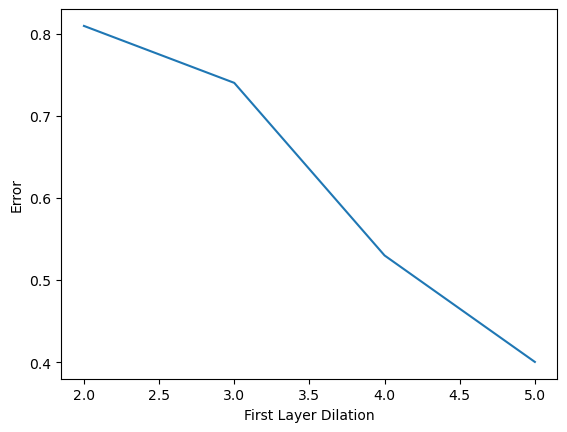

In [92]:
fig, axes = plt.subplots()
axes.plot(dilations, [1 - e for e in error_dilation])
axes.set_xlabel("First Layer Dilation")
axes.set_ylabel("Error")

### Dilation and Stride
Stride reduces resolution of each layer on an already small resolution image which does not help. Significant underfitting.
Increasing Dilation also increases error.